# Airglow modeling: the Python framework

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from importlib import reload
from scipy import interpolate
import sys
from scipy import signal
import obspy

import airglow_response as ar

## First step: generate seismograms
To obtain airglow waveform, we must first generate the surface excitation. This is done through a Seismograms class. For now, the Seismograms class produces waveforms exclusively through Pyrocko, using a pre-calculated Green's functions store. In the future, it can eventually build synthetic waveforms using other methods, like Normal Modes. 

25600
25600


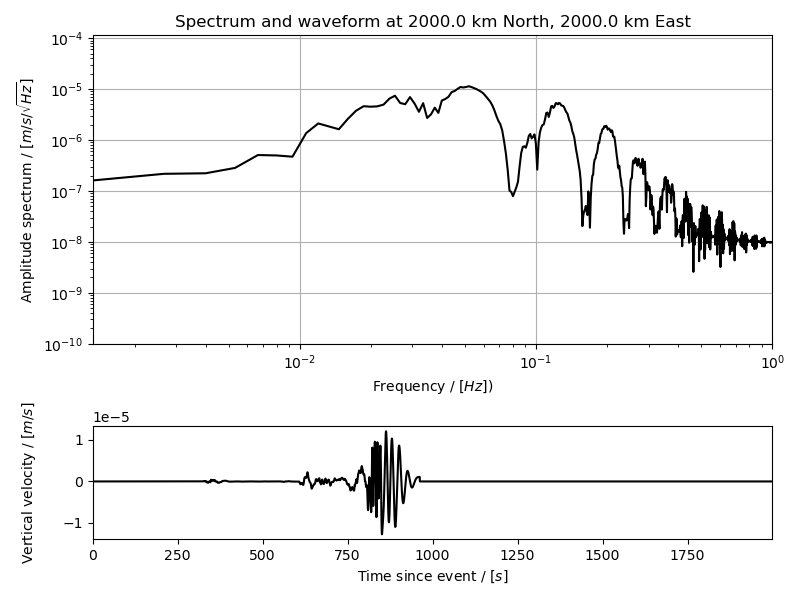

In [23]:
reload(ar)
### OPTION 1: Create a synthetic at point locations 
gridded      = False
ns, es       = 2000e3, 2000e3
depths       = 15.e3 
north_shifts = np.array([ns, ns/2, ns/3])
east_shifts  = np.array([es, es/2, ns/3])

### OPTION 2: Create synthetics on a dense grid: 
gridded       = True
delta_dist    = 50e3
min_grid_dist = 0e3
max_grid_dist = 4000e3 # 4000e3
north_shifts  = np.arange(-max_grid_dist, max_grid_dist, delta_dist)
east_shifts   = np.arange(-max_grid_dist, max_grid_dist, delta_dist)

print(east_shifts.size * north_shifts.size)

### Option for Pyrocko 
opt_synthetics = dict(
    ### Options for source 
    mw = 6.5,
    depth = depths,
    strike = 0., 
    dip = 45., 
    rake = 45.,
    #stf_type = None,
    stf_type = 'triangle', 
    #stf_type = 'sinus', 
    effective_duration = 25.,
    ###  
    ### Options for store
    base_folder='/projects/restricted/infrasound/data/infrasound/2023_Venus_inversion/',
    ### Old option, single store 
    #store_id = 'GF_venus_Cold100_qssp',
    #store_id = 'GF_venus_Cold100_qssp_grid',
    ### Give store names, and min and max valid distance 
    store_ids_dists = [('GF_venus_Cold100_qssp',50e3,8000e3),('GF_venus_Cold100_qssp_nearfield',0e3,50e3)],
    ###
    ### Options for grid 
    north_shifts = north_shifts, 
    east_shifts = east_shifts,
    gridded=gridded
)

### INITIALIZE SEISMOGRAM CLASS 
SEISMO = ar.Seismograms(**opt_synthetics)
print(len(SEISMO.synthetic_traces_u))


### Plot one of the waveforms for check
fig = SEISMO.plot_traces(ns, es)

### Arrange the synthetics
Sort them by their location in the appropriate grid. Interpolate in time from $t=0$ to $t=tmax$.

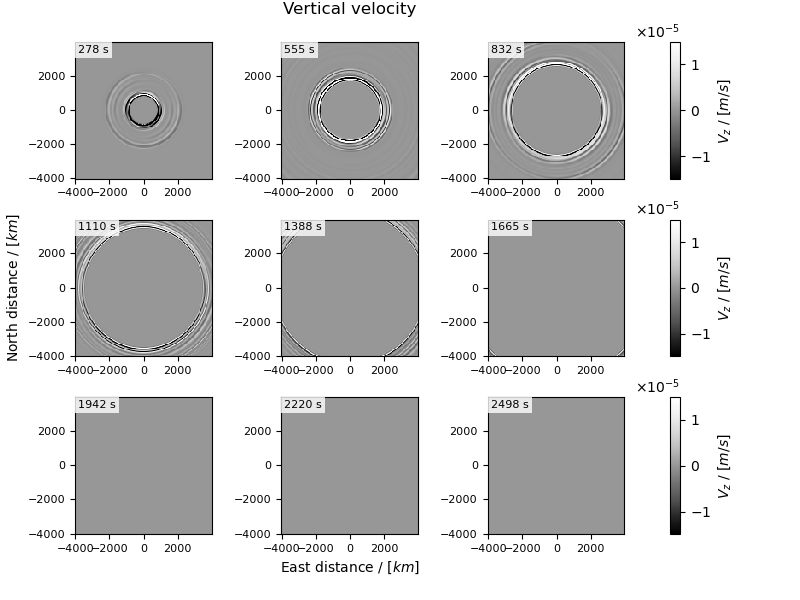

In [24]:
reload(ar)
fig = SEISMO.arrange_interpolate_synthetics()

### Plot velocity wavefront at the surface for sanity check 
fig = SEISMO.plot_wavefront()

## Initialise the AirglowSignal class
This class inherits information from the Seismograms class, and loads information about the atmosphere and Volume Emission Rates.

In [46]:
### Load airglow class 
reload(ar)
AIRGLOW = ar.AirglowSignal(SEISMO)

### Calculate the Airglow waveforms
Can be done in parallel or serial / with gridded or point by point locations.

In [51]:
reload(ar)

### Define the locations we are interested in: 
list_inorth= [0,1]
### If the result is not gridded, only give list_inorth
if not gridded:
    list_ieast = [0 for j in range(len(list_inorth))]
### Else, meshgrid 
else: 
    #list_inorth, list_ieast = np.meshgrid(list_inorth, list_inorth)
    # list_inorth = list_inorth.ravel()
    # list_ieast  = list_ieast.ravel()
    ### To get all the grid: 
    list_inorth, list_ieast = AIRGLOW.iNN, AIRGLOW.iEE

### Define the location at which we want to save high-resolution waveforms:
e_save, n_save = 3000e3, -3000e3
loc_save_en = [(e_save, n_save), (500e3,500e3), (50e3,50e3)]
### Calculate the 1.27 micrometer airglow 
AIRGLOW.calculate_1_27_airglow(list_inorth, list_ieast, loc_save_EN = loc_save_en, do_parallel=True)

### Can also eventually give a list of indices
#ie_save, in_save = (70,50)
#loc_save_idx = [(ie_save, in_save), (50,50)]
### Calculate the 1.27 micrometer airglow 
#AIRGLOW.calculate_1_27_airglow(list_inorth, list_ieast, loc_save_idx = loc_save_idx, do_parallel=True)

[(20, 140), (90, 90), (81, 81)]


100%|████████████████████████████████████████| 25600/25600 [00:30<00:00, 833.24it/s]                                                                          


Time for airglow calculation: 31.4 s


### Display various signals for a location
This plotting function helps us verify our calculation by displaying:

1. The vertical velocity seismogram on the top
2. The velocity propagated vertically upward and attenuated
3. The associated dVER
4. The integrated dVER, giving the Intensity, supposedly in photons/m2/s

1 29


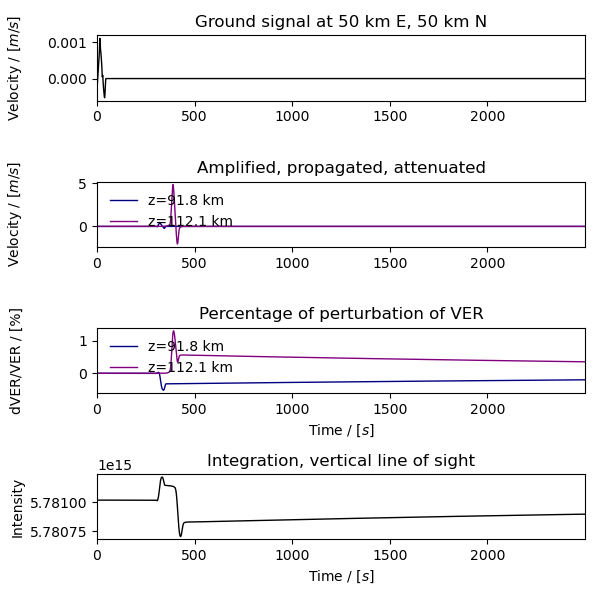

In [53]:
reload(ar)
e_save, n_save = 50e3, 50e3
AIRGLOW.plot_nightglow_traces(loc_plot=[e_save, n_save])

### Display airglowgrams
Airglowgrams are obtained by integrating dVER over the line of sight of an observer. 
For now the calculation is very simple and assumes a vertical line of sight (observer infinitely far away and flat planet). 

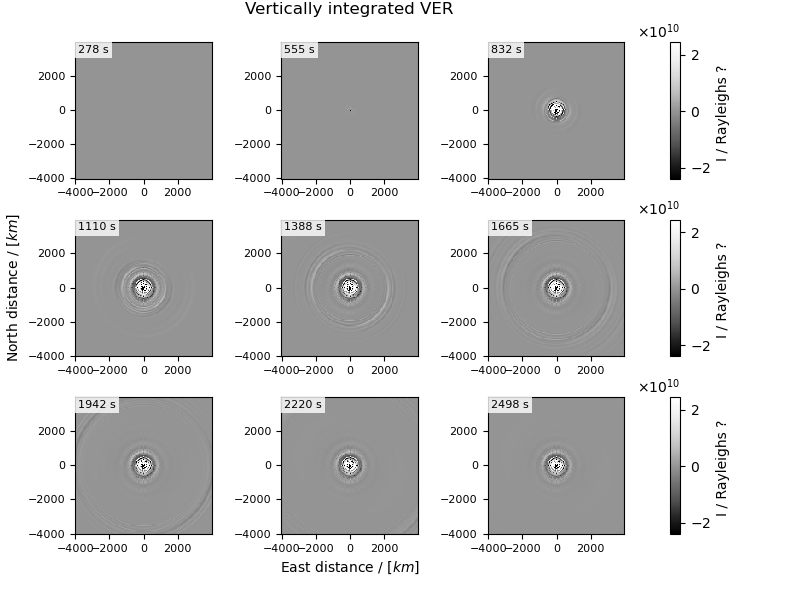

In [49]:
reload(ar)
AIRGLOW.plot_nightglow_images()

### Comparison of Partial Gradient and Full Gradient
Result obtained at a specific pixel when using $\nabla([VER]\vec{v})$ or $[VER]\nabla(\vec{v})$.

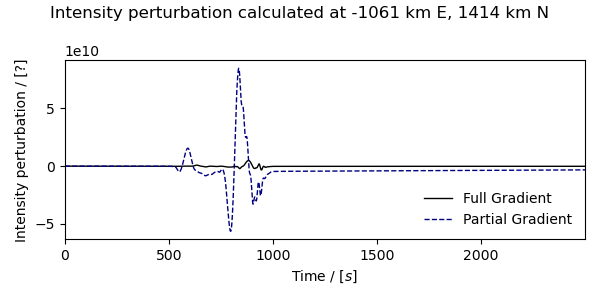

In [41]:
#e_save, n_save = 50, 50
e_save, n_save = 120, 50

full_grad = np.load("./results/I_1_27_{:d}_{:d}_fullgrad.npy".format(e_save, n_save))
part_grad = np.load("./results/I_1_27_{:d}_{:d}_partialgrad.npy".format(e_save, n_save))

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(AIRGLOW.t_new, full_grad, c="k", lw=1, label="Full Gradient")
ax.plot(AIRGLOW.t_new, part_grad, c="navy", ls="--", lw=1, label="Partial Gradient")
ax.set_xlabel(r"Time / [$s$]")
ax.set_ylabel(r"Intensity perturbation / [?]")
ax.set_xlim(AIRGLOW.t_new.min(), AIRGLOW.t_new.max())
ax.legend(loc=4, frameon=False)
fig.suptitle("Intensity perturbation calculated at {:.0f} km E, {:.0f} km N".format(
                AIRGLOW.EE[e_save, n_save]/1e3,AIRGLOW.NN[e_save, n_save]/1e3)
            )
fig.tight_layout()
fig.savefig("./Figures/compare_full_partial_grad_{:d}_{:d}".format(e_save, n_save))
